### Dropout:  A Simple Way to Prevent Neural Networks from overfitting <br> http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

As the title itself says, dropouts helps the problem of overfitting in neural networks. Large networks are required to deal with feature heavy data, which can result in overfitting easily. Averaging results of many neural networks are almost always better the training and testing on single network, but computationally is very expensive. Dropout provides a way of approximately combining exponentially many different neural network architectures efficiently.  Dropouts can also be thought of adding random noises to its hidden units while network is asked to consistently try to produce error free output. We can think that as we drop some of the units with probability p, the remaining hidden units learn independent of the removed units.<br>
Dropping out 20% of the input units and 50% of the hidden units are often found to be optimal.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def loadCIFARData():
    import pickle
    train_x = [];
    train_y = [];
    for batchNo in range(1,6):
        with open('./cifar-10-batches-py/data_batch_'+str(batchNo), 'rb') as fo:
            dicti = pickle.load(fo, encoding='bytes')
            for d in dicti[b'data']:
                train_x.append(d.reshape(3,32,32).transpose(1,2,0))
            for d in dicti[b'labels']:
                train_y.append(d)
    test_x = [];
    test_y = [];
    with open('./cifar-10-batches-py/test_batch', 'rb') as fo:
        dicti = pickle.load(fo, encoding='bytes')
        for d in dicti[b'data']:
            test_x.append(d.reshape(3,32,32).transpose(1,2,0))
        for d in dicti[b'labels']:
            test_y.append(d)
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

train_x, train_y, test_x, test_y = loadCIFARData();

print("Training data :")
print("Number of examples :", train_x.shape[0])
print("Individual image size :",train_x.shape[1:])
print("\nTest data :")
print("Number of examples :", test_x.shape[0])

Training data :
Number of examples : 50000
Individual image size : (32, 32, 3)

Test data :
Number of examples : 10000


### Now that we have loaded the data, let's see couple of images!

(-0.5, 159.5, 159.5, -0.5)

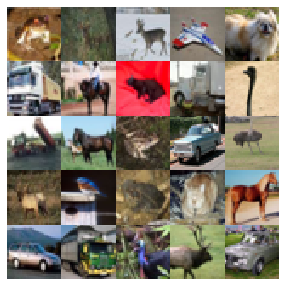

In [2]:
plot = train_x[0:5,:,:,:].reshape(160,32,3)
for i in range(1,5):
    image = train_x[10*i:10*i+5,:,:,:].reshape(160,32,3)
    plot = np.append(plot, image, axis=1)

fig= plt.figure(figsize=(5,5))
plt.imshow(plot)
plt.axis('off')

#### The images are in RGB i.e. 3 channels of pixel values in range 0-255. We need to do some pre-processing of the data, so that our data is normalized and standardised i.e. mean = 0 and stdDev = 1. Such preprocessing of the data helps speed up the convergence process. Note that, in this case though, we need not necessarily do normalization, because values of all the pixels are in fixed range. However normalizing inputs may impose larger weights and may save us from diminishing gradient issues. Let's do it!

In [3]:
from keras.utils import np_utils

totalClasses = 10 #CIFAR-10

mean = []; std = []; #channel wise mean and std of pixel values
for i in range(3):
    mean.append(np.mean(train_x[:,:,:,i]))
    std.append(np.std(train_x[:,:,:,i]))
newTrain_x = np.ones(train_x.shape)
newTest_x = np.ones(test_x.shape)
for i in range(3):
    newTrain_x[:,:,:,i] = (train_x[:,:,:,i] - mean[i])/std[i]
    newTest_x[:,:,:,i] = (test_x[:,:,:,i] - mean[i])/std[i]
train_x = newTrain_x
test_x = newTest_x

#also change labels to one hot vectors
train_y = np_utils.to_categorical(train_y, totalClasses)
test_y = np_utils.to_categorical(test_y, totalClasses)

Using TensorFlow backend.


In [4]:
batchSize = 2048
learningRate= 0.001
learningRateDecay = 0.95

In [6]:
from keras.models  import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam

scores = []
dropouts = [ 0.0, 0.5, 0.9 ]
for dropout in dropouts:
    print("Dropout: ", (dropout))
    model = Sequential()
    
    model.add(Convolution2D(64, (3, 3), input_shape=(32,32,3), padding='valid'))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(64, (3, 3)))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))
                   
    model.add(Convolution2D(128, (3, 3)))
    model.add(Dropout(dropout)) 
    model.add(Activation('relu'))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))
                     
    model.add(Convolution2D(256, (3, 3)))
    model.add(Dropout(dropout)) 
    model.add(Activation('relu'))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())                                                
    model.add(Dense(512))                                               
    model.add(Activation('relu'))                                       

    model.add(Dense(512))                                                
    model.add(Activation('relu'))
    
    model.add(Dense(totalClasses))                                     

    model.add(Activation('softmax'))
    
    model.compile( loss='categorical_crossentropy', optimizer=Adam(lr=learningRate, decay=learningRateDecay),
                  metrics=['accuracy'] )
    model.fit(train_x, train_y, batch_size=batchSize, shuffle=True, epochs=20)
    score = model.evaluate(test_x, test_y)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    scores.append(score)

Dropout:  0.0
Epoch 1/20
50000/50000 [==============================] - 139s 3ms/step - loss: 2.0267 - acc: 0.2773
Epoch 2/20
50000/50000 [==============================] - 134s 3ms/step - loss: 1.8311 - acc: 0.3447
Epoch 3/20
50000/50000 [==============================] - 129s 3ms/step - loss: 1.7667 - acc: 0.3704
Epoch 4/20
50000/50000 [==============================] - 177s 4ms/step - loss: 1.7273 - acc: 0.3842
Epoch 5/20
50000/50000 [==============================] - 165s 3ms/step - loss: 1.6997 - acc: 0.3949
Epoch 6/20
50000/50000 [==============================] - 82s 2ms/step - loss: 1.6791 - acc: 0.4015
Epoch 7/20
50000/50000 [==============================] - 70s 1ms/step - loss: 1.6624 - acc: 0.4057
Epoch 8/20
50000/50000 [==============================] - 70s 1ms/step - loss: 1.6490 - acc: 0.4103
Epoch 9/20
50000/50000 [==============================] - 70s 1ms/step - loss: 1.6378 - acc: 0.4146
Epoch 10/20
50000/50000 [==============================] - 70s 1ms/step - loss: 1

## What do we learn?
Using dropouts reduces our rate of learning significantly, probably because of random drops of weights that could have been modified to quickly reach the optimal solution. We also see that our per epoch timings has increased as well. However this is the price we pay to get regularized neural networks. Regularization is important so that the network doesn't just memorize the input training data, rather create abstractions for the prediction model.<br>Comparing different between accuracy on training and test data, we see that using appropriate value of dropout, we see better performance on test data as compared to training data, than we see without any dropout value set. In this setting, it seems we would need to run the model for few more iterations, when dropout is being used. But results show that dropout helps regularize the model and provide better accuracy on non-training data, than would have been without dropout. We also see bad effects of high dropout rate i.e. with high dropout network would be tiny and won't be able to learn something useful for our classification problem.